# Advanced Machine Learning
## Project 1 - Optimization Algorithms
### Authors: Bartosz Grabek, Izabela Telejko, Grzegorz Zbrzeżny

In [6]:
import numpy as np
from utils.train_functions import cv
from utils.preprocess_functions import(
    preprocess_booking,
    preprocess_churn,
    preprocess_employee,
    preprocess_challenger,
    preprocess_jungle,
    preprocess_water
)
from utils.IWLS import IWLS
from utils.GD import GD
from utils.plots import plot_figures_for_cv

### TODO:
Some columns in X_challenger and X_jungle have only 0 values

In [2]:
sgd_acc_list, adam_acc_list, iwls_acc_list, l_iwls_vals_list, l_sgd_vals_list, l_adam_vals_list = cv(preprocess_churn)

CV fold 1
Removing multicolinear columns in churn dataset...


Epochs: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.94it/s]


Balanced accuracy of GD without optimizer is: 0.6209367612293144
Balanced accuracy of SGD with ADAM is: 0.6921542553191489
Balanced accuracy of IWLS is: 0.7136524822695035
Balanced accuracy of LR from Scikit is 0.720596926713948
CV fold 2
Removing multicolinear columns in churn dataset...


Epochs: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.79it/s]


Balanced accuracy of GD without optimizer is: 0.5541822362747916
Balanced accuracy of SGD with ADAM is: 0.6590255820638115
Balanced accuracy of IWLS is: 0.6723914918079907
Balanced accuracy of LR from Scikit is 0.6723914918079907
CV fold 3
Removing multicolinear columns in churn dataset...


Epochs: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.21it/s]


Balanced accuracy of GD without optimizer is: 0.49964070135096295
Balanced accuracy of SGD with ADAM is: 0.6815176774935325
Balanced accuracy of IWLS is: 0.6677924691003162
Balanced accuracy of LR from Scikit is 0.637180224202357
CV fold 4
Removing multicolinear columns in churn dataset...


Epochs: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.31it/s]


Balanced accuracy of GD without optimizer is: 0.5793617021276596
Balanced accuracy of SGD with ADAM is: 0.6222695035460992
Balanced accuracy of IWLS is: 0.6451773049645391
Balanced accuracy of LR from Scikit is 0.6387234042553191
CV fold 5
Removing multicolinear columns in churn dataset...


Epochs: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.76it/s]


Balanced accuracy of GD without optimizer is: 0.5823013415892673
Balanced accuracy of SGD with ADAM is: 0.6482628138974889
Balanced accuracy of IWLS is: 0.6253009975920193
Balanced accuracy of LR from Scikit is 0.6253009975920193


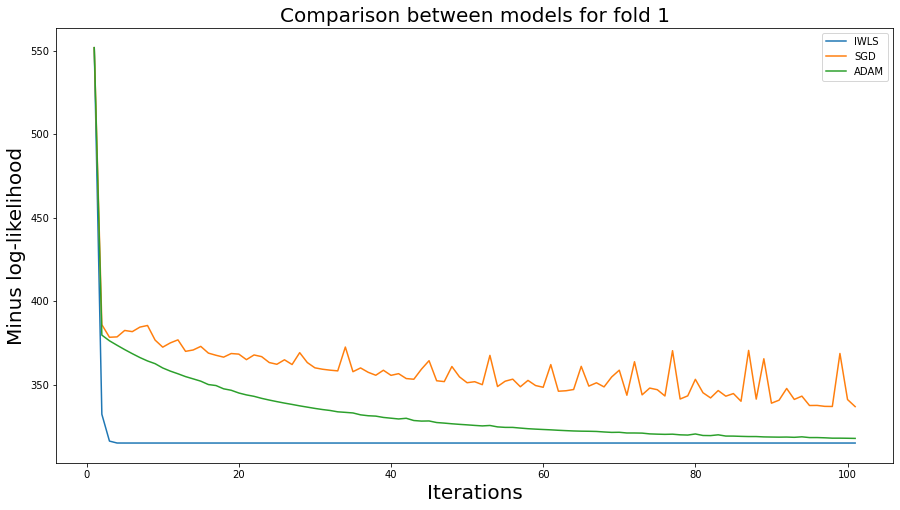

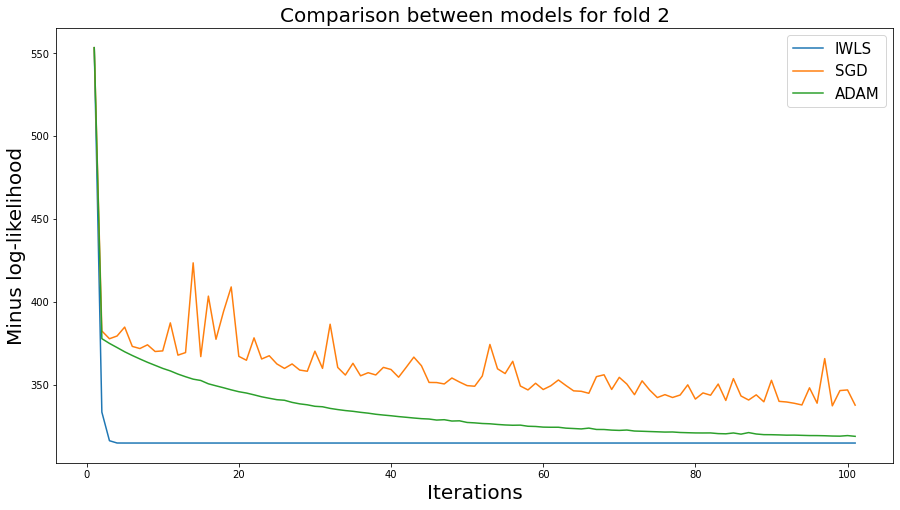

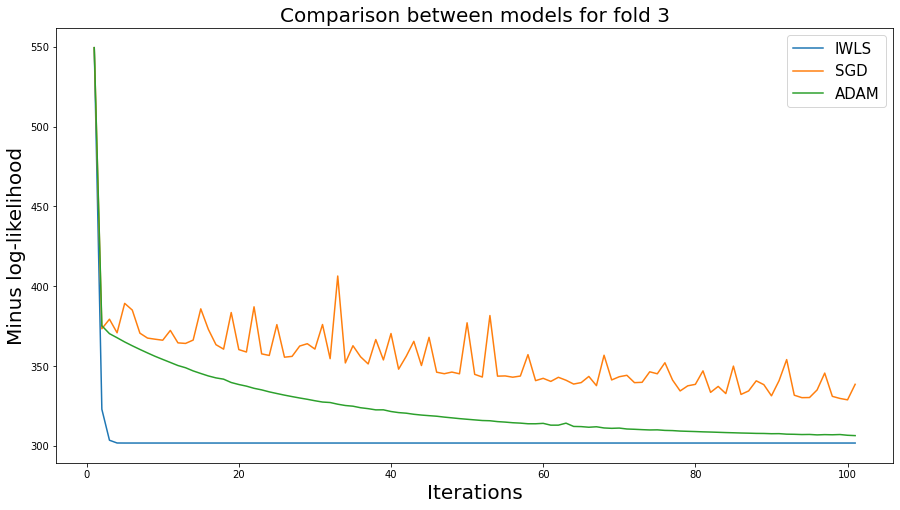

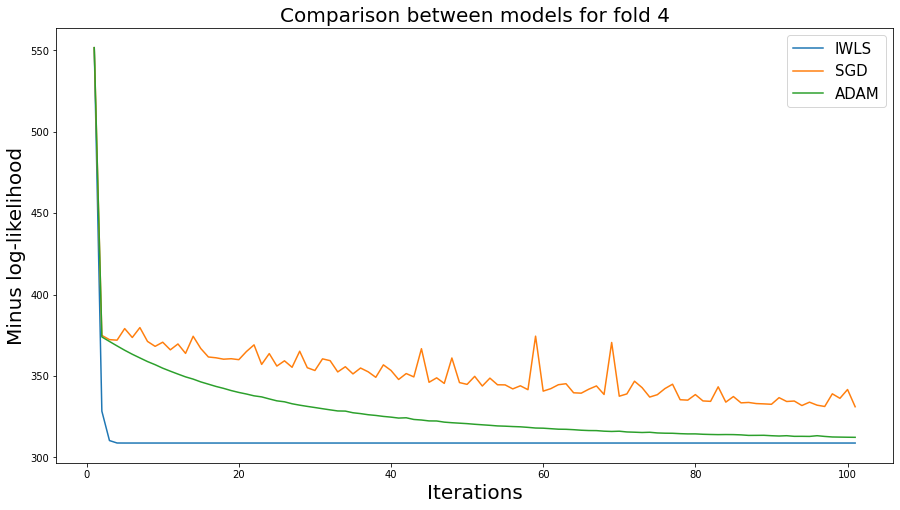

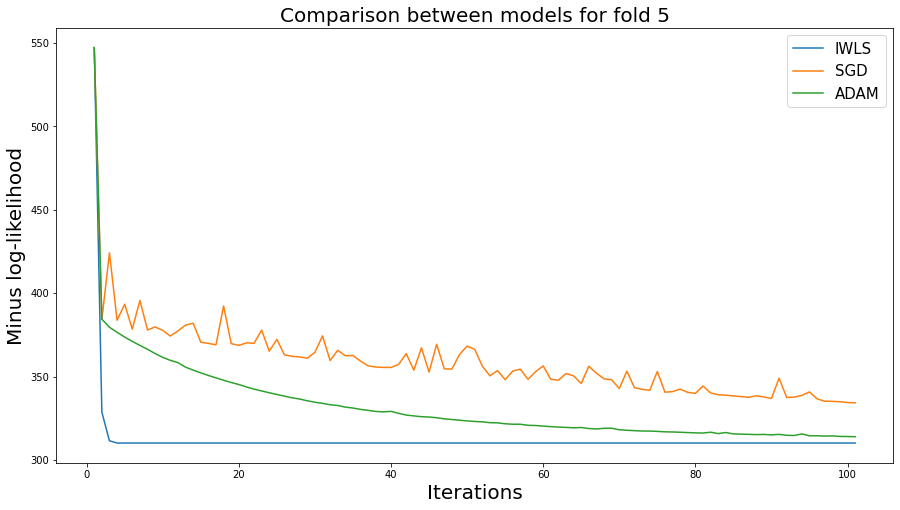

In [3]:
plot_figures_for_cv(l_iwls_vals_list, l_sgd_vals_list, l_adam_vals_list)

### Data generated from logistic model

In [21]:
beta1 = 2

n1 = 1000
x1 = np.random.exponential(1, size=n1)

n2 = 1000
x2 = np.random.exponential(1/(beta1+1), size=n2)

X = np.expand_dims(np.concatenate((x1, x2), axis=0), axis=1)
X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
y = np.expand_dims(np.concatenate((np.ones((1, n1)), np.zeros((1, n2))), axis=1)[0], 1)

In [22]:
pi = n1 / (n1 + n2)
b0 = -np.log((1 + beta1) * ((1-pi)/pi))

In [23]:
l_iwls_vals, best_beta_iwls = IWLS(X, y, n_iter=100, print_likeli=False)
l_sgd_vals, best_beta_sgd = GD(X, y, 0.0002, n_epoch=200, print_likeli=False, use_adam=False)
l_adam_vals, best_beta_adam = GD(X, y, 0.0002, n_epoch=200, print_likeli=False)

Epochs: 100%|████████████████████████████████████████████████████████████████████████| 200/200 [00:21<00:00,  9.28it/s]


In [24]:
print(f"Theoretical betas: b0: {b0}, b1: {beta1}" )
print(f"Empirical betas for SGD without optimizers: b0: {best_beta_sgd[0]}, b1: {best_beta_sgd[1]}")
print(f"Empirical betas for SGD with ADAM: b0: {best_beta_adam[0]}, b1: {best_beta_adam[1]}")
print(f"Empirical betas for IWLS: b0: {best_beta_iwls[0][0]}, b1: {best_beta_iwls[1][0]}")

Theoretical betas: b0: -1.0986122886681098, b1: 2
Empirical betas for SGD without optimizers: b0: -0.9548698689263471, b1: 1.8114309314006518
Empirical betas for SGD with ADAM: b0: -1.0361494471123969, b1: 1.967674856031902
Empirical betas for IWLS: b0: -1.0317018922327175, b1: 1.9636630619051219
